In [1]:
import os
import gc
import numpy as np

from scipy.optimize import curve_fit
from obspy import UTCDateTime
from pandas import DataFrame, date_range

import matplotlib.pyplot as plt

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename == 'lin-ffb-01':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

In [3]:
config = {}

config['path_to_data'] = data_path+"ids/data/"

config['path_to_outdata'] = data_path+"ids/data/"

config['path_to_figures'] = data_path+"ids/figures/"

## experiment 1
config['date1'] = "2024-01-29"
config['date2'] = "2024-02-05"

## experiment 2
config['date1'] = "2024-02-15"
config['date2'] = "2024-02-23"

## experiment 2
config['date1'] = "2024-03-09"
config['date2'] = "2024-03-19"


In [4]:
from functions.load_mlti import __load_mlti
from functions.get_mlti_intervals import __get_mlti_intervals
from functions.mlti_intervals_to_NaN import __mlti_intervals_to_NaN

In [5]:
mltiU = __load_mlti(config['date1'], config['date2'], "U", archive_path)
mltiU_t1, mltiU_t2 = __get_mlti_intervals(mltiU.time_utc)

In [6]:
def __load_beam_wander_data(tbeg, tend, path_to_data):

    from obspy import UTCDateTime
    from datetime import date
    from pandas import read_pickle, concat, DataFrame, date_range, to_datetime

    t1 = date.fromisoformat(str(UTCDateTime(tbeg).date))
    t2 = date.fromisoformat(str((UTCDateTime(tend)).date))

    df = DataFrame()
    for dat in date_range(t1, t2):
        print(str(dat)[:10])
        file = f"{str(dat)[:10].replace('-','')}.pkl"
        try:
            df0 = read_pickle(path_to_data+file)
            df = concat([df, df0])
        except:
            print(f"error for {file}")

    # remove NaN from time column
    df.dropna(subset=['time'], inplace=True)

    # reset the index column
    df.reset_index(inplace=True, drop=True)

    # add column for relative time in seconds
    df['time_sec'] = [UTCDateTime(_t) - UTCDateTime(df.time.iloc[0]) for _t in df.time]

    return df

In [7]:
df = __load_beam_wander_data(config['date1'], config['date2'], config['path_to_data'])

2024-03-09
2024-03-10
2024-03-11
2024-03-12
2024-03-13
error for 20240313.pkl
2024-03-14
error for 20240314.pkl
2024-03-15
2024-03-16
2024-03-17
2024-03-18
2024-03-19
error for 20240319.pkl


### Remove MLTI times

In [8]:

# local time to utc (! correct only in winter)
df['time_utc'] = [UTCDateTime(tl)-3600 for tl in df.time]


# pixel to length
conversion_factor = 1.67e-3 # mm / pixel

keys_to_convert = ["y_idx", "x_idx", "y", "x"]

for k in keys_to_convert:
    df[k] *= conversion_factor

# turn times with MLTI to NaN
df = __mlti_intervals_to_NaN(df, "y_idx", "time_utc", mltiU_t1, mltiU_t2, t_offset_sec=180)
df = __mlti_intervals_to_NaN(df, "x_idx", "time_utc", mltiU_t1, mltiU_t2, t_offset_sec=180)


In [9]:
df

,time,x,y,x_idx,y_idx,amp,x_sig,y_sig,theta,offset,...,y_var,amp_var,y_sig_var,x_sig_var,theta_var,offset_var,time_sec,time_utc,y_idx_nan,x_idx_nan
0,2024-03-09T00:16:04.000000Z,3.448152,1.623167,3.44688,1.62324,118.640974,512.482534,488.616501,0.442582,9.262870,...,0.004833,0.000277,0.006100,0.006563,0.000004,0.000021,0.0,2024-03-08T23:16:04.000000Z,1.62324,3.44688
1,2024-03-09T00:18:04.000000Z,3.448166,1.623070,3.44688,1.62324,118.576590,512.446876,488.572016,0.442970,9.261224,...,0.004832,0.000277,0.006098,0.006561,0.000004,0.000021,120.0,2024-03-08T23:18:04.000000Z,1.62324,3.44688
2,2024-03-09T00:32:04.000000Z,3.448276,1.623338,3.44688,1.62324,118.430879,512.472021,488.643493,0.443508,9.262004,...,0.004837,0.000276,0.006104,0.006567,0.000004,0.000021,960.0,2024-03-08T23:32:04.000000Z,1.62324,3.44688
3,2024-03-09T00:45:05.000000Z,3.448335,1.623647,3.44688,1.62324,118.532076,512.453585,488.643372,0.443924,9.255072,...,0.004839,0.000277,0.006106,0.006569,0.000004,0.000021,1741.0,2024-03-08T23:45:05.000000Z,1.62324,3.44688
4,2024-03-09T00:51:04.000000Z,3.448354,1.623493,3.44688,1.62324,118.460598,512.491885,488.660101,0.443797,9.259604,...,0.004840,0.000277,0.006107,0.006571,0.000004,0.000021,2100.0,2024-03-08T23:51:04.000000Z,1.62324,3.44688
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
909,2024-03-18T00:53:04.000000Z,3.475482,1.630118,3.47527,1.62992,116.567075,512.792587,488.825252,0.452329,9.104065,...,0.004915,0.000272,0.006196,0.006679,0.000004,0.000021,779820.0,2024-03-17T23:53:04.000000Z,NaN,NaN
910,2024-03-18T00:58:05.000000Z,3.475364,1.630570,3.47527,1.62992,116.316842,512.767164,488.863247,0.454480,9.091391,...,0.004922,0.000271,0.006203,0.006686,0.000005,0.000021,780121.0,2024-03-17T23:58:05.000000Z,NaN,NaN
911,2024-03-18T01:07:04.000000Z,3.475513,1.630381,3.47527,1.62992,116.454576,512.763214,488.793267,0.451909,9.105428,...,0.004915,0.000271,0.006195,0.006679,0.000004,0.000021,780660.0,2024-03-18T00:07:04.000000Z,NaN,NaN
912,2024-03-18T01:14:04.000000Z,3.475638,1.630379,3.47527,1.62992,116.707746,512.787464,488.808263,0.453357,9.111631,...,0.004917,0.000272,0.006198,0.006682,0.000004,0.000021,781080.0,2024-03-18T00:14:04.000000Z,NaN,NaN


### Plotting

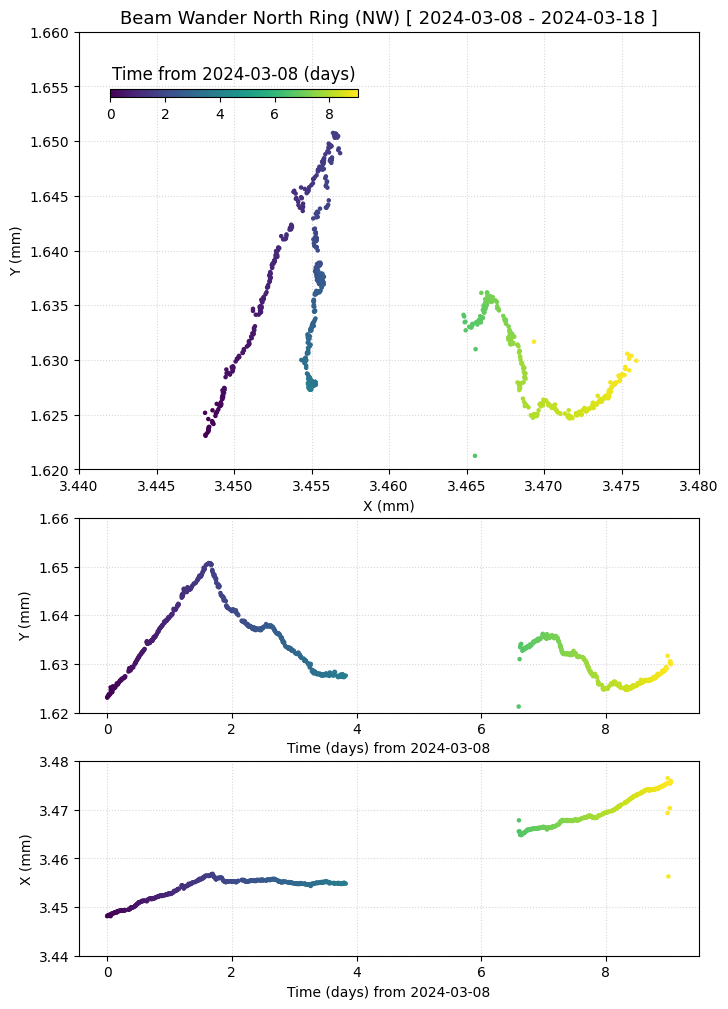

In [20]:
def __makeplot_beam_wander(df0):

    import matplotlib.pyplot as plt
    from matplotlib.gridspec import GridSpec

    time_scaling = 1/86400

    Ncol, Nrow = 2, 4

    font = 12

    fig = plt.figure(figsize=(8, 12))

    gs = GridSpec(Nrow, Ncol, figure=fig)

    ax1 = fig.add_subplot(gs[0:2, :])

    ax2 = fig.add_subplot(gs[2, :])
    ax3 = fig.add_subplot(gs[3, :])

    plt.subplots_adjust(hspace=0.25)


    # ax1.scatter(df0.x_idx, df0.y_idx, c=df0.time_sec*time_scaling, s=5, zorder=2)
    cb = ax1.scatter(df0.x, df0.y, c=df0.time_sec*time_scaling, s=5, zorder=2)



    ax2.scatter(df0.time_sec*time_scaling, df0.y, c=df0.time_sec*time_scaling, s=5, zorder=2)
    ax3.scatter(df0.time_sec*time_scaling, df0.x, c=df0.time_sec*time_scaling, s=5, zorder=2)

    ax1.set_ylabel("Y (mm)")
    ax1.set_xlabel("X (mm)")

    ax2.set_ylabel("Y (mm)")
    ax2.set_xlabel(f"Time (days) from {str(df.time_utc.iloc[0])[:10]}")

    ax3.set_ylabel("X (mm)")
    ax3.set_xlabel(f"Time (days) from {str(df.time_utc.iloc[0])[:10]}")

    for ax in [ax1, ax2, ax3]:
        ax.grid(ls=":", alpha=0.5, zorder=0)

    x1, x2 = 3.44, 3.48
    y1, y2 = 1.62, 1.66
    ax1.set_xlim(x1, x2)
    ax1.set_ylim(y1, y2)
    ax2.set_ylim(y1, y2)
    ax3.set_ylim(x1, x2)

    # add title
    ax1.set_title(f"Beam Wander North Ring (NW) [ {df0.time_utc.iloc[0].date} - {df0.time_utc.iloc[-1].date} ]", fontsize=font+1)

    # add colorbar
    cax1 = ax1.inset_axes([0.05, 0.85, 0.4, 0.02])
    cb5 = plt.colorbar(cb, ax=ax1, cax=cax1, orientation="horizontal")
    cb5.set_label(f"Time from {df0.time_utc.iloc[0].date} (days)", fontsize=font, labelpad=-40)


    plt.show();
    return fig

fig = __makeplot_beam_wander(df)

fig.savefig(config['path_to_figures']+f"BeamWander_RU.png", format="png", dpi=150, bbox_inches='tight')
